In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect
"""

NEMO_DIR_PATH = "NeMo"
BRANCH = 'main'

! git clone https://github.com/NVIDIA/NeMo
%cd NeMo
! python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
%cd ..

fatal: destination path 'NeMo' already exists and is not an empty directory.
/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/NeMo
DEPRECATION: git+https://github.com/NVIDIA/NeMo.git@main#egg=nemo_toolkit[all] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to /tmp/pip-install-jzk787rv/nemo-toolkit_8b7fd0d8d4604f698bce9560c3cb06d4
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/NeMo.git /tmp/pip-install-jzk787rv/nemo-toolkit_8b7fd0d8d4604f698bce9560c3cb06d4
  Resolved https://github.com/NVIDIA/NeMo.git to commit 88816f0b87364ee539731a0f59f298e958ab68f9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Usi

# Speaker Diarization Training

## Neural Diarizer in Speaker Diarization Pipeline

<img src="images/diar_pipeline.png" alt="diar_pipeline" style="width: 800px;"/>

Speaker diarization system needs to capture the characteristics of unseen speakers from the given audio recording and generate speaker-homogeneous segments which belong to corresponding speaker labels. During the speaker diarization process, the number of speakers should be estimated, then the audio segments should be assigned to a few of speaker labels. 

While clustering algorithms can also assign segments to speaker groups, overlap-aware diarization cannot be done with clustering based diarizer since one segment is only assigned to one speaker label. However, we can use the clustering result to create initial speaker profiles and train a neural model that generates overlap-aware speaker labels by comparing the input audio signal with the initial speaker profiles. In the NeMo speaker diarization toolkit, we refer to such neural modules as **neural diarizer**. 

The Multi-scale Diarization Decoder (MSDD) model is a type of neural diarizer we can use in the NeMo speaker diarization pipeline. This tutorial shows how to train MSDD on a small toy dataset. By using MSDD on top of clustering diarizer, we can obtain the following benefits:

- **Improved diarization accuracy**: Compared to clustering diarizer, MSDD could achieve a lower diarization error rate (DER)
- **Overlap aware diarization**: Speaker diarization results in clustering diarizer do not include speech overlaps
- **Model training on actual multispeaker dataset**: Unlike training a speaker embedding model, we can train or finetune a neural model on an actual speaker diarization dataset where multiple speakers are recorded in a single audio file. 

### Training and inference of Multi-scale Diarization Decoder

When it comes to the speaker diarization problem, MSDD model employs a divide-and-conquer strategy where a pairwise model is employed for both training and inference. The following figure explains how a pairwise model is employed for training and inference.

<img src="images/msdd_train_and_infer.png" alt="MSDD_train_infer" style="width: 800px;"/>

Here are itemized descriptions of noteworthy features of the MSDD model.

#### Training 

- **Oracle VAD, multi-scale segmentation for training**   
In a training setup, we use oracle VAD from ground-truth annotation files (RTTM files) and perform multiscale segmentation. After we obtain timestamps for each and every segment, we feed multi-scale timestamps and raw audio signals into a computational graph where the speaker embedding extractor and neural diarizer is trained.  

   
- **MSDD inputs for training process**  
During training, we employ oracle clustering result (ground-truth speaker labels in the annotation file) to calculate the cluster-average embeddings. Subsequently, we calculate binary cross-entropy loss which calculates a loss value for each timestep and each speaker.


- **End-to-end training: from raw audio to speaker label**   
The training approach we employ can be considered as end-to-end training since the input to the computational graph is raw audio signal and the outputs are speaker labels. The end-to-end training is depicted in a dotted box in the above figure. We can either freeze the speaker embedding model or train it jointly depending on the tasks.   


- **Pairwise (two-speaker) unit model**   
While training the MSDD model, we use a two-speaker dataset for a two speaker model. For this pairwise training, we clean the source dataset to have only two speakers by splitting the annotation.   


- **Split training samples**  
Since we have finite GPU memory for training, we break down the training audio samples into short audio samples. We set step-count, and step-count indicates a unit of decision for speaker label estimation. We set step-count (e.g., `step_count=50`) when we create training datasets and use the step-count for training.    

#### Inference

- **Multi-scale clustering**  
In inference mode, we apply multi-scale clustering for obtaining speaker profiles that are represented by cluster-average embedding.   


- **Divide-and-conquer approach with pairwise (two-speaker) unit model**   
We retrieve all possible pairs from the estimated number of speakers and average the results. For example, if there are four speakers `(A, B, C, D)`, we extract 6 pairs: `(A,B)`, `(A,C)`, `(A,D)`, `(B,C)`, `(B,D)`, `(C,D)`. Finally, the sigmoid outputs are averaged. In this way, MSDD can deal with a flexible number of speakers using a pairwise model.


- **Split inference samples**  
As in the training process, we can also break down the target samples for inference. While we can do inference on whole input audio at once, split inference generally gives an improved performance. It is recommended to use the same step-count you used for training the MSDD model (e.g., `diar_window_length=50`) for your inference configurations.

### Input and Output of Multi-scale Diarization Decoder

While using an MSDD model as neural diarizer has a few benefits, MSDD models require a clustering result to obtain initial speaker profiles as references for performing overlap-aware speaker diarization inference.  Here are descriptions for input and output of the MSDD model.

#### Input: Clustering as Initialization

MSDD model is a diarizer model that accepts two different data inputs:

 1. Cluster-average embeddings
 2. Multi-scale embedding sequence 
 
The two input signals are depicted in the following figure.

<img src="images/msdd_inputs.png" alt="MSDD_inputs" style="width: 600px;"/>

By initializing the diarization task with a clustering algorithm, we can estimate the number of speakers and cluster-average embeddings. Thus, the cluster-average embeddings provide the speaker profile of each speaker. The cluster-average embeddings we provide can be regarded as reference signals for providing seed speaker profiles.

Once we obtain the fixed (or estimated) number of speakers, the speaker diarization problem becomes a binary classification task where we need to estimate whether a certain speaker's speech exists or not at a given timestep.  

#### Output: Sigmoid Output and Binary Cross-entropy Loss

<img src="images/msdd_output_loss.png" alt="MSDD_output_loss" style="width: 600px;"/>

The above figure depicts the inputs and outputs of the MSDD model. As an output from MSDD, sigmoid values for each speaker are generated. These sigmoid values are independent from the other speakers and indicate the simulated probability of the corresponding speaker's speech signal at the given step. During the training process, binary cross-entropy (BCE) is calculated for each individual sigmoid value and summed up to calculate the total loss for optimization.

## Example Data Creation

- Please skip this section and go directly to [Prepare Training data for MSDD](#Prepare-Training-data-for-MSDD) section if you have your own speaker diarization dataset. 

In this tutorial, we use [NeMo Multispeaker Simulator](https://github.com/NVIDIA/NeMo/blob/main/tutorials/tools/Multispeaker_Simulator.ipynb) and the Librispeech corpus to generate a toy training dataset for demonstration purpose. You can replace the simulated dataset with your own datasets if you have proper speaker annotations (RTTM files) for the dataset. If you do not have access to any speaker diarization datasets, you can use [NeMo Multispeaker Simulator](https://github.com/NVIDIA/NeMo/blob/main/tutorials/tools/Multispeaker_Simulator.ipynb) by generating a good amount of data samples to meet your needs. 

For more details regarding data simulator, please follow the descriptions in [NeMo Multispeaker Simulator](https://github.com/NVIDIA/NeMo/blob/main/tutorials/tools/Multispeaker_Simulator.ipynb) and we will not cover configurations and detailed process of data simulation in this tutorial. 


In [2]:
# Install dependencies for data simulator
!pip install sox libsndfile1 ffmpeg
!pip install wget
!pip install unidecode
!pip install "matplotlib>=3.3.2"

ERROR: Could not find a version that satisfies the requirement libsndfile1 (from versions: none)
ERROR: No matching distribution found for libsndfile1


#### Data Simulation Step 1:  Download Required Resources

We need to download the LibriSpeech corpus and corresponding word alignments for generating synthetic multi-speaker audio sessions. In addition, we need to download necessary data cleaning scripts from NeMo git.

In [3]:
import os
NEMO_DIR_PATH = "NeMo"
BRANCH = 'main'

# download scripts if not already there 
if not os.path.exists('NeMo/scripts'):
  print("Downloading necessary scripts")
  !mkdir -p NeMo/scripts/dataset_processing
  !mkdir -p NeMo/scripts/speaker_tasks
  !wget -P NeMo/scripts/dataset_processing/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/dataset_processing/get_librispeech_data.py
  !wget -P NeMo/scripts/speaker_tasks/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/speaker_tasks/create_alignment_manifest.py
  !wget -P NeMo/scripts/speaker_tasks/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/speaker_tasks/create_msdd_train_dataset.py  
  !wget -P NeMo/scripts/speaker_tasks/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/speaker_tasks/pathfiles_to_diarize_manifest.py

Now that we have downloaded all the necessary scripts for data creation and preparation, we can start the data simulation step by downloading the LibriSpeech corpus.

In [4]:
!mkdir -p LibriSpeech
!python {NEMO_DIR_PATH}/scripts/dataset_processing/get_librispeech_data.py \
  --data_root LibriSpeech \
  --data_sets dev_clean

100%|███████████████████████████████████████████| 97/97 [00:03<00:00, 24.96it/s]


We can get the forced word alignments data for the LibriSpeech corpus from [this repository.](https://github.com/CorentinJ/librispeech-alignments). Full forced alignments data can be downloaded at [google drive link for alignments data](https://drive.google.com/file/d/1WYfgr31T-PPwMcxuAq09XZfHQO5Mw8fE/view?usp=sharing). We will download only a subset of forced alignment data containing dev-clean part.

In [5]:
!wget -nc https://dldata-public.s3.us-east-2.amazonaws.com/LibriSpeech_Alignments.tar.gz
!tar -xzf LibriSpeech_Alignments.tar.gz
!rm -f LibriSpeech_Alignments.tar.gz

--2023-05-13 15:45:33--  https://dldata-public.s3.us-east-2.amazonaws.com/LibriSpeech_Alignments.tar.gz
Resolving dldata-public.s3.us-east-2.amazonaws.com (dldata-public.s3.us-east-2.amazonaws.com)... 52.219.178.122
Connecting to dldata-public.s3.us-east-2.amazonaws.com (dldata-public.s3.us-east-2.amazonaws.com)|52.219.178.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284061 (277K) [application/x-gzip]
Saving to: ‘LibriSpeech_Alignments.tar.gz’

100%[======================================>] 284,061      245KB/s   in 1.1s   

2023-05-13 15:45:35 (245 KB/s) - ‘LibriSpeech_Alignments.tar.gz’ saved [284061/284061]



#### Data Simulation Step 2:  Produce Manifest File with Forced Alignments

We will merge the LibriSpeech manifest files and LibriSpeech forced alignments into one manifest file for ease of use when generating synthetic data. Create alignment files by running the following script.



In [6]:
!python NeMo/scripts/speaker_tasks/create_alignment_manifest.py \
  --input_manifest_filepath LibriSpeech/dev_clean.json \
  --base_alignment_path LibriSpeech_Alignments \
  --output_manifest_filepath ./dev-clean-align.json \
  --ctm_output_directory ./ctm_out \
  --libri_dataset_split dev-clean

[NeMo W 2023-05-13 15:45:43 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-05-13 15:45:45 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo I 2023-05-13 15:45:46 create_alignment_manifest:123] Removing existing output directory: ./ctm_out
[NeMo I 2023-05-13 15:45:46 create_alignment_manifest:126] Creating output directory: ./ctm_out
[NeMo I 2023-05-13 15:45:51 create_alignment_manifest:245] Writing output manifest file to ./dev-clean-align.json


#### Data Simulation Step 3:  Set data simulation parameters

Now that we have downloaded all the sources we need for data creation, we need to download data simulator configurations in `.yaml` format. Download the YAML file and download `data_simulator.py` script from NeMo repository.

In [7]:
from omegaconf import OmegaConf
import os
ROOT = os.getcwd()
conf_dir = os.path.join(ROOT,'conf')
!mkdir -p $conf_dir
CONFIG_PATH = os.path.join(conf_dir, 'data_simulator.yaml')
if not os.path.exists(CONFIG_PATH):
  !wget -P $conf_dir https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/tools/speech_data_simulator/conf/data_simulator.yaml

config = OmegaConf.load(CONFIG_PATH)
print(OmegaConf.to_yaml(config))

data_simulator:
  manifest_filepath: ???
  sr: 16000
  random_seed: 42
  multiprocessing_chunksize: 10000
  session_config:
    num_speakers: 4
    num_sessions: 60
    session_length: 600
  session_params:
    max_audio_read_sec: 20.0
    sentence_length_params:
    - 0.4
    - 0.05
    dominance_var: 0.11
    min_dominance: 0.05
    turn_prob: 0.875
    min_turn_prob: 0.5
    mean_silence: 0.15
    mean_silence_var: 0.01
    per_silence_var: 900
    per_silence_min: 0.0
    per_silence_max: -1
    mean_overlap: 0.1
    mean_overlap_var: 0.01
    per_overlap_var: 900
    per_overlap_min: 0.0
    per_overlap_max: -1
    start_window: true
    window_type: hamming
    window_size: 0.05
    start_buffer: 0.1
    split_buffer: 0.1
    release_buffer: 0.1
    normalize: true
    normalization_type: equal
    normalization_var: 0.1
    min_volume: 0.75
    max_volume: 1.25
    end_buffer: 0.5
  outputs:
    output_dir: ???
    output_filename: multispeaker_session
    overwrite_output: true

#### Data Simulation Step 4:   Generate Simulated Audio Session

We will generate a set of example sessions with the following specifications:

- 3 example sessions for train  
- 3 example sessions for validation
- 2-speakers in each session
- 60 seconds of recordings

We need to setup different seed for train and validation sets.

In [8]:
from nemo.collections.asr.data.data_simulation import MultiSpeakerSimulator

# Generate train set 
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'simulated_train')
config.data_simulator.random_seed=10
config.data_simulator.manifest_filepath="./dev-clean-align.json"
config.data_simulator.outputs.output_dir=data_dir
config.data_simulator.session_config.num_sessions=3
config.data_simulator.session_config.num_speakers=2
config.data_simulator.session_config.session_length=60
config.data_simulator.background_noise.add_bg=False 

lg = MultiSpeakerSimulator(cfg=config)
lg.generate_sessions()

# Generate validation set 
data_dir = os.path.join(ROOT,'simulated_valid')
config.data_simulator.random_seed=20
config.data_simulator.outputs.output_dir=data_dir

lg = MultiSpeakerSimulator(cfg=config)
lg.generate_sessions()

[NeMo W 2023-05-13 15:46:05 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-05-13 15:46:06 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.


[NeMo I 2023-05-13 15:46:07 data_simulation_utils:453] Building speaker to samples map...


100%|██████████| 2698/2698 [00:00<00:00, 1753638.96it/s]

[NeMo I 2023-05-13 15:46:07 data_simulation:302] Total 40 speakers in the source dataset.
[NeMo I 2023-05-13 15:46:07 data_simulation:303] Initialized speaker permutations for 3 sessions with 2 speakers each.
[NeMo I 2023-05-13 15:46:07 data_simulation:1190] Generating Diarization Sessions



[1/1] Waiting jobs from  1 to  3: 100%|██████████| 3/3 [00:05<00:00,  1.93s/jobs]

[NeMo I 2023-05-13 15:46:13 data_simulation:1273] Data simulation has been completed, results saved at: /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_train
[NeMo I 2023-05-13 15:46:13 data_simulation_utils:453] Building speaker to samples map...



100%|██████████| 2698/2698 [00:00<00:00, 1313702.37it/s]

[NeMo I 2023-05-13 15:46:13 data_simulation:302] Total 40 speakers in the source dataset.
[NeMo I 2023-05-13 15:46:13 data_simulation:303] Initialized speaker permutations for 3 sessions with 2 speakers each.
[NeMo I 2023-05-13 15:46:13 data_simulation:1190] Generating Diarization Sessions



[1/1] Waiting jobs from  1 to  3: 100%|██████████| 3/3 [00:00<00:00,  3.73jobs/s]

[NeMo I 2023-05-13 15:46:14 data_simulation:1273] Data simulation has been completed, results saved at: /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_valid


Now that parameter setting is done, generate the samples by launching `generate_sessions()`.

In [9]:
lg = MultiSpeakerSimulator(cfg=config)
lg.generate_sessions()

[NeMo I 2023-05-13 15:46:18 data_simulation_utils:453] Building speaker to samples map...


100%|██████████| 2698/2698 [00:00<00:00, 1255127.79it/s]

[NeMo I 2023-05-13 15:46:18 data_simulation:302] Total 40 speakers in the source dataset.
[NeMo I 2023-05-13 15:46:18 data_simulation:303] Initialized speaker permutations for 3 sessions with 2 speakers each.
[NeMo I 2023-05-13 15:46:18 data_simulation:1190] Generating Diarization Sessions



[1/1] Waiting jobs from  1 to  3: 100%|██████████| 3/3 [00:00<00:00,  3.89jobs/s]

[NeMo I 2023-05-13 15:46:19 data_simulation:1273] Data simulation has been completed, results saved at: /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_valid


### Data preparation step 5: Listen to and Visualize Session

Listen to the audio and visualize the corresponding speaker timestamps (recorded in a RTTM file for each session).

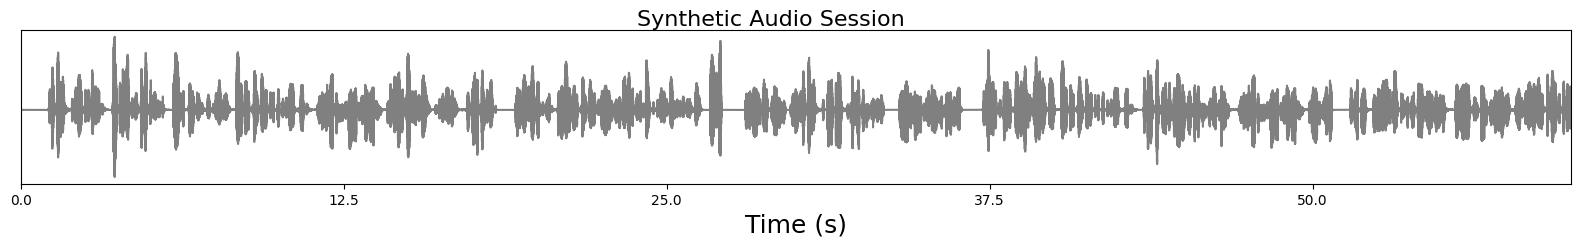

In [10]:
import os
import wget
import IPython
import matplotlib.pyplot as plt
import numpy as np
import librosa
from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels, labels_to_pyannote_object

ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'simulated_train')
audio = os.path.join(data_dir,'multispeaker_session_0.wav')
rttm = os.path.join(data_dir,'multispeaker_session_0.rttm')

sr = 16000
signal, sr = librosa.load(audio,sr=sr) 

fig,ax = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(np.arange(len(signal)),signal,'gray')
fig.suptitle('Synthetic Audio Session', fontsize=16)
plt.xlabel('Time (s)', fontsize=18)
plt.yticks([], [])
ax.margins(x=0)
a,_ = plt.xticks()
plt.xticks(a[:-1],a[:-1]/sr);
IPython.display.Audio(audio)

We can visually check the ground-truth file of the first sample by running the following commands. We can see that it has plenty of overlap between two speakers. 

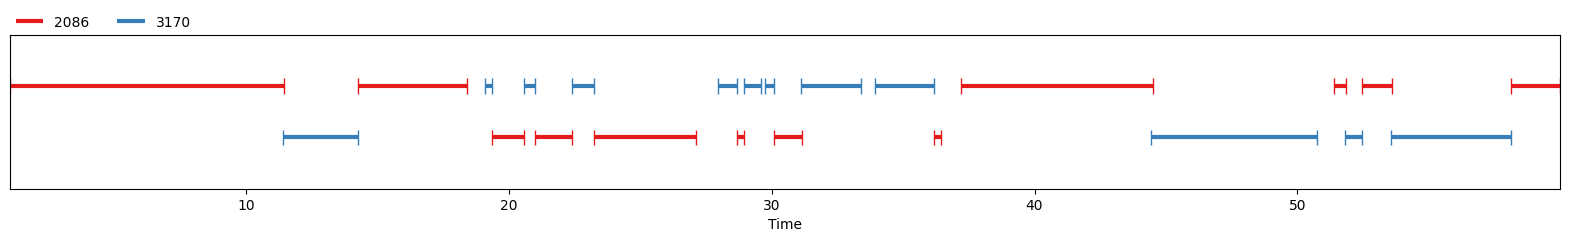

In [11]:
# display speaker labels for reference
labels = rttm_to_labels(rttm)
reference = labels_to_pyannote_object(labels)
reference

You can check that corresponding RTTM files are generated as ground-truth labels for training and evaluation.

In [12]:
!cat simulated_train/multispeaker_session_0.rttm | head -10

SPEAKER multispeaker_session_0 1   1.023   10.440 <NA> <NA> 2086 <NA> <NA>
SPEAKER multispeaker_session_0 1   11.407   2.860 <NA> <NA> 3170 <NA> <NA>
SPEAKER multispeaker_session_0 1   14.248   4.150 <NA> <NA> 2086 <NA> <NA>
SPEAKER multispeaker_session_0 1   19.101   0.260 <NA> <NA> 3170 <NA> <NA>
SPEAKER multispeaker_session_0 1   19.357   1.230 <NA> <NA> 2086 <NA> <NA>
SPEAKER multispeaker_session_0 1   20.582   0.410 <NA> <NA> 3170 <NA> <NA>
SPEAKER multispeaker_session_0 1   20.987   1.410 <NA> <NA> 2086 <NA> <NA>
SPEAKER multispeaker_session_0 1   22.394   0.850 <NA> <NA> 3170 <NA> <NA>
SPEAKER multispeaker_session_0 1   23.224   3.901 <NA> <NA> 2086 <NA> <NA>
SPEAKER multispeaker_session_0 1   27.957   0.710 <NA> <NA> 3170 <NA> <NA>


### Data preparation step 6: Check out the created files

The following files are generated from data simulator:

* _wav files_ (one per audio session) - the output audio sessions
* _rttm files_ (one per audio session) - the speaker timestamps for the corresponding audio session (used for diarization training)
* _list files_ (one per file type per batch of sessions) - a list of generated files of the given type (e.g., wav, rttm), used primarily for manifest creation

Check if the files we need are generated by running the following commands.

In [13]:
print("\n Training audio files:")
!ls simulated_train/*.wav
print("\n Training audio files:")
!ls simulated_train/*.rttm
print("\n Training RTTM list content:")
!cat simulated_train/synthetic_wav.list
print("\n Training RTTM list content:")
!cat simulated_train/synthetic_rttm.list

print("\n Validation audio files:")
!ls simulated_valid/*.wav
print("\n Validation audio files:")
!ls simulated_valid/*.rttm
print("\n Validation RTTM list content:")
!cat simulated_valid/synthetic_wav.list
print("\n Validation RTTM list content:")
!cat simulated_valid/synthetic_rttm.list


 Training audio files:
simulated_train/multispeaker_session_0.wav
simulated_train/multispeaker_session_1.wav
simulated_train/multispeaker_session_2.wav

 Training audio files:
simulated_train/multispeaker_session_0.rttm
simulated_train/multispeaker_session_1.rttm
simulated_train/multispeaker_session_2.rttm

 Training RTTM list content:
/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_train/multispeaker_session_0.wav
/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_train/multispeaker_session_1.wav
/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_train/multispeaker_session_2.wav
 Training RTTM list content:
/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_train/multispeaker_session_0.rttm
/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_train/multispeaker_session_1.rttm
/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_train/multispeaker_session_2.rttm
 Validation audio files:
simulated_valid/

## Prepare Training Data for MSDD

Now that we have datasets for both train and validation (dev), we can start preparing and cleaning the data samples for training. Make sure you have the following list of files:

**Training set** 

- Train audio files `.wav`
- A train audio list file `.list`
- Train RTTM files `.rttm`
- A train RTTM list content `.list`

**Validation set**  

- Validation audio files `.wav`
- A validation audio list file `.list`
- Validation RTTM files `.rttm`
- A validation RTTM list file `.list`


Based on these files, we need to create manifest files containing data samples we have. If you don't have a `.list` file, you need to create a `.list` file for the `.wav` files and `.rttm` files.

In [14]:
# create a NeMo manifest (.json) file for training dataset
!python NeMo/scripts/speaker_tasks/pathfiles_to_diarize_manifest.py \
  --paths2audio_files='simulated_train/synthetic_wav.list' \
  --paths2rttm_files='simulated_train/synthetic_rttm.list' \
  --manifest_filepath='simulated_train/msdd_data.json'

# create a NeMo manifest (.json) file for validation (dev) dataset
!python NeMo/scripts/speaker_tasks/pathfiles_to_diarize_manifest.py \
  --paths2audio_files='simulated_valid/synthetic_wav.list' \
  --paths2rttm_files='simulated_valid/synthetic_rttm.list' \
  --manifest_filepath='simulated_valid/msdd_data.json'

[NeMo W 2023-05-13 15:46:48 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-05-13 15:46:50 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-05-13 15:46:57 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-05-13 15:46:59 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.


If you print the content of the created manifest file, you can see that `.rttm` files in the list and `.wav` files are grouped together in the generated manifest files.

In [15]:
print("\n An example line in training dataset manifest file:")
!cat simulated_train/msdd_data.json | head -1
print("\n An example line in validation Dataset manifest file:")
!cat simulated_valid/msdd_data.json | head -1


 An example line in training dataset manifest file:
{"audio_filepath": "/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_train/multispeaker_session_0.wav", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": 2, "rttm_filepath": "/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_train/multispeaker_session_0.rttm", "uem_filepath": null, "ctm_filepath": null}

 An example line in validation Dataset manifest file:
{"audio_filepath": "/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_valid/multispeaker_session_0.wav", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": 2, "rttm_filepath": "/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_valid/multispeaker_session_0.rttm", "uem_filepath": null, "ctm_filepath": null}


Now that we have input a standard manifest file, we need to break down each audio clip into short audio clips so that we can put several samples in a batch. 

Before we generate a manifest file and RTTM files for training MSDD, you have to determine:

- `window`: the window length of the base scale (the shortest scale)
- `shift`: the hop-length of the base scale (the shortest scale)
- `step_count`: how many decision steps in one data sample

Note that these numbers should match the parameters in the configurations for your desired MSDD model. If you want to train with new parameters (`window`, `shift` and `step_count`), you need to make new manifest files with the new parameters.

In [16]:
# create a manifest (.json) file for training dataset
!python NeMo/scripts/speaker_tasks/create_msdd_train_dataset.py \
  --input_manifest_path='simulated_train/msdd_data.json' \
  --output_manifest_path='simulated_train/msdd_data.50step.json' \
  --pairwise_rttm_output_folder='simulated_train/' \
  --window 0.5 \
  --shift 0.25 \
  --step_count 50 
  
# create a manifest (.json) file for validation (dev) dataset
!python NeMo/scripts/speaker_tasks/create_msdd_train_dataset.py \
  --input_manifest_path='simulated_valid/msdd_data.json' \
  --output_manifest_path='simulated_valid/msdd_data.50step.json' \
  --pairwise_rttm_output_folder='simulated_valid/' \
  --window 0.5 \
  --shift 0.25 \
  --step_count 50 

[NeMo W 2023-05-13 15:47:15 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-05-13 15:47:17 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo I 2023-05-13 15:47:18 speaker_utils:93] Number of files to diarize: 3
[NeMo I 2023-05-13 15:47:18 create_msdd_train_dataset:88] Creating split RTTM files.
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 925.69it/s]
[NeMo I 2023-05-13 15:47:18 create_msdd_train_dataset:159] Creating subsegments.
[NeMo W 2023-05-13 15:47:24 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-05-13 15:47:26 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. U

Now that we broke down the training and validation dataset into 50-step samples, let's checkout how the output manifest files look like. We used 0.25 second of shift length so in theory, if there is no silence or pause in the data, the length of data sample should be `step_count*shift` which is `50*0.25=12.5` second in the example we used. However, since there are pauses between the segments in practice, the final lengths of data samples are longer than 12.5 second.

In [17]:
print("\nTraining Dataset:")
!cat simulated_train/msdd_data.50step.json | tail -5
print("\nValidation Dataset:")
!cat simulated_valid/msdd_data.50step.json | tail -5 


Training Dataset:
{"audio_filepath": "/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_train/multispeaker_session_1.wav", "offset": 12.559, "duration": 14.691, "label": "infer", "text": "-", "num_speakers": 2, "rttm_filepath": "simulated_train/multispeaker_session_1.652_5694.rttm", "uem_filepath": null, "ctm_filepath": null}
{"audio_filepath": "/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_train/multispeaker_session_1.wav", "offset": 26.75, "duration": 14.397, "label": "infer", "text": "-", "num_speakers": 2, "rttm_filepath": "simulated_train/multispeaker_session_1.652_5694.rttm", "uem_filepath": null, "ctm_filepath": null}
{"audio_filepath": "/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/simulated_train/multispeaker_session_2.wav", "offset": 0.035, "duration": 15.511, "label": "infer", "text": "-", "num_speakers": 2, "rttm_filepath": "simulated_train/multispeaker_session_2.5338_6319.rttm", "uem_filepath": null, "ctm_filepath": null}
{"audio

## Train an MSDD Model

Now that we have prepared all the necessary dataset, we can train an MSDD model on the prepared dataset. Download YAML file for training form NeMo repository and load the configuration into `config` variable.

In [18]:
import nemo
import nemo.collections.asr as nemo_asr
from omegaconf import OmegaConf

NEMO_ROOT = os.getcwd()
!mkdir conf 
!wget -P conf https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/speaker_tasks/diarization/conf/neural_diarizer/msdd_5scl_15_05_50Povl_256x3x32x2.yaml
MODEL_CONFIG = os.path.join(NEMO_ROOT,'conf/msdd_5scl_15_05_50Povl_256x3x32x2.yaml')
config = OmegaConf.load(MODEL_CONFIG)
print(OmegaConf.to_yaml(config))

mkdir: cannot create directory ‘conf’: File exists
--2023-05-13 15:47:36--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/neural_diarizer/msdd_5scl_15_05_50Povl_256x3x32x2.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5621 (5.5K) [text/plain]
Saving to: ‘conf/msdd_5scl_15_05_50Povl_256x3x32x2.yaml.2’

100%[======================================>] 5,621       --.-K/s   in 0s      

2023-05-13 15:47:36 (31.6 MB/s) - ‘conf/msdd_5scl_15_05_50Povl_256x3x32x2.yaml.2’ saved [5621/5621]

name: MultiscaleDiarDecoder
sample_rate: 16000
num_workers: 20
batch_size: 7
model:
  diarizer:
    out_dir: null
    oracle_vad: true
    speaker_embeddings:
      model_path: ???
      parameters:
        window_length_in_sec:
  

Setup the `manifest_filepath` for `train_ds` and `validation_ds` by feeding the `json` file paths from `create_msdd_train_dataset.py`.

In [19]:
config.model.train_ds.manifest_filepath = 'simulated_train/msdd_data.50step.json'
config.model.validation_ds.manifest_filepath = 'simulated_valid/msdd_data.50step.json'

### Train MSDD with frozen speaker embedding model

Provide a batch size number for training in `config.model.batch_size`. In a batch, we will assign the given number of split samples (in this example, 50 step-size). Note that you might need to change this batch size if the following batch size maxes out your GPU memory size. 

`config.model.emb_batch_size` determines the number of embedding vectors attached to a computational graph. This means that 
If you want to freeze the speaker embedding extractor, you should set `emb_batch_size=0`.
If you want to jointly optimize speaker embedding extractor, you need to assign an adequate number that does not max out the GPU memory. 

In [20]:
config.batch_size=5
config.model.emb_batch_size=0

Provide paths to the temporary folders for saving timestamp data during training.

In [21]:
config.model.train_ds.emb_dir="simulated_train" 
config.model.validation_ds.emb_dir="simulated_valid" 

Setup a speaker embedding model that will be used for speaker embedding extraction. We will use `titanet_large` model checkpoint from NGC. Note that this speaker embedding model will be saved together in a `.ckpt` file whenever pytorch lightning trainer saves checkpoint. 

In [22]:
config.model.diarizer.speaker_embeddings.model_path="titanet_large"
config.trainer.max_epochs = 5
config.trainer.strategy = None

We will use `pytorch_lightning` and train a model instance from class `EncDecDiarLabelModel`.

In [23]:
import pytorch_lightning as pl
from nemo.collections.asr.models import EncDecDiarLabelModel
from nemo.utils.exp_manager import exp_manager

trainer = pl.Trainer(**config.trainer)
exp_manager(trainer, config.get("exp_manager", None))
msdd_model = EncDecDiarLabelModel(cfg=config.model, trainer=trainer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


[NeMo I 2023-05-13 15:47:43 exp_manager:374] Experiments will be logged at /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/nemo_experiments/MultiscaleDiarDecoder/2023-05-13_15-47-43
[NeMo I 2023-05-13 15:47:43 exp_manager:797] TensorboardLogger has been set up
[NeMo I 2023-05-13 15:47:43 collections:612] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-13 15:47:43 collections:615] Total 9 session files loaded accounting to # 9 audio clips
[NeMo I 2023-05-13 15:47:43 speaker_utils:93] Number of files to diarize: 9
[NeMo I 2023-05-13 15:47:43 speaker_utils:1467] Extracting oracle VAD timestamps and saving at simulated_train/speaker_outputs
[NeMo I 2023-05-13 15:47:43 speaker_utils:1485] Subsegmentation for timestamp extracted for: scale-0 at simulated_train/speaker_outputs/subsegments_scale0.json
[NeMo I 2023-05-13 15:47:43 speaker_utils:1506] Extracting timestamps from simulated_train/speaker_outputs/subsegments_scale0.json for multiscale subsegmentation.
[Ne

[NeMo W 2023-05-13 15:47:44 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2023-05-13 15:47:44 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method 

[NeMo I 2023-05-13 15:47:44 features:287] PADDING: 16
[NeMo I 2023-05-13 15:47:45 save_restore_connector:249] Model EncDecSpeakerLabelModel was successfully restored from /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo.


Before we start training, let's check a few of the weights in the speaker embedding model in `msdd_model.msdd._speaker_model`.

In [24]:
msdd_model.msdd._speaker_model.state_dict()["encoder.encoder.0.mconv.0.conv.weight"][0,:,:]

tensor([[-0.0577,  0.4153, -0.0502]], device='cuda:0')

If you successfully ran the previous step, now it is ready to initiate a training session of MSDD. Launch `trainer.fit()` function for `msdd_model`. 

In [25]:
trainer.fit(msdd_model)

You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


[NeMo I 2023-05-13 15:47:54 modelPT:722] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 0.001
        maximize: False
        weight_decay: 0.001
    )
[NeMo I 2023-05-13 15:47:54 lr_scheduler:910] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f6ec856fd30>" 
    will be used during training (effective maximum steps = 10) - 
    Parameters : 
    (min_lr: 1.0e-05
    max_steps: 10
    )



  | Name            | Type                              | Params
----------------------------------------------------------------------
0 | preprocessor    | AudioToMelSpectrogramPreprocessor | 0     
1 | msdd            | MSDD_module                       | 31.1 M
2 | loss            | BCELoss                           | 0     
3 | _accuracy_test  | MultiBinaryAccuracy               | 0     
4 | _accuracy_train | MultiBinaryAccuracy               | 0     
5 | _accuracy_valid | MultiBinaryAccuracy               | 0     
----------------------------------------------------------------------
31.1 M    Trainable params
0         Non-trainable params
31.1 M    Total params
124.451   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[NeMo W 2023-05-13 15:47:54 nemo_logging:349] /home/auishik/miniconda3/envs/nemo/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2023-05-13 15:47:56 nemo_logging:349] /home/auishik/miniconda3/envs/nemo/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    


Training: 0it [00:00, ?it/s]

[NeMo I 2023-05-13 15:47:56 preemption:56] Preemption requires torch distributed to be initialized, disabling preemption


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 2: 'val_loss' reached 125.79488 (best 125.79488), saving model to '/home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/nemo_experiments/MultiscaleDiarDecoder/2023-05-13_15-47-43/checkpoints/MultiscaleDiarDecoder--val_loss=125.7949-epoch=0.ckpt' as top 30


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.25 GiB (GPU 0; 23.70 GiB total capacity; 7.86 GiB already allocated; 219.69 MiB free; 9.34 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In this way, you can train an MSDD model and use `.ckpt` files saved during training process.

Let's check the weights in speaker embedding model again and see if the numbers are changed.

In [ ]:
msdd_model.msdd._speaker_model.state_dict()["encoder.encoder.0.mconv.0.conv.weight"][0,:,:]

tensor([[-0.0577,  0.4153, -0.0502]])

### Train MSDD and speaker embedding model together

In this time, let's attach a few speaker embeddings to a graph and jointly train the speaker embedding mode.

In [ ]:
config.model.emb_batch_size = 100 # choose the largest number that does not max out GPU memory.
config.trainer.max_epochs = 5

Setup another trainer and initiate a training session with the new parameters.

In [26]:
trainer = pl.Trainer(**config.trainer)
exp_manager(trainer, config.get("exp_manager", None))
msdd_model = EncDecDiarLabelModel(cfg=config.model, trainer=trainer)
trainer.fit(msdd_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


[NeMo I 2023-05-13 15:51:27 exp_manager:374] Experiments will be logged at /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/nemo_experiments/MultiscaleDiarDecoder/2023-05-13_15-47-43
[NeMo I 2023-05-13 15:51:27 exp_manager:797] TensorboardLogger has been set up
[NeMo I 2023-05-13 15:51:27 collections:612] Filtered duration for loading collection is 0.000000.
[NeMo I 2023-05-13 15:51:27 collections:615] Total 9 session files loaded accounting to # 9 audio clips
[NeMo I 2023-05-13 15:51:27 speaker_utils:93] Number of files to diarize: 9
[NeMo I 2023-05-13 15:51:27 speaker_utils:1467] Extracting oracle VAD timestamps and saving at simulated_train/speaker_outputs
[NeMo I 2023-05-13 15:51:27 speaker_utils:1485] Subsegmentation for timestamp extracted for: scale-0 at simulated_train/speaker_outputs/subsegments_scale0.json
[NeMo I 2023-05-13 15:51:27 speaker_utils:1506] Extracting timestamps from simulated_train/speaker_outputs/subsegments_scale0.json for multiscale subsegmentation.
[Ne

[NeMo W 2023-05-13 15:51:28 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2023-05-13 15:51:28 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method 

[NeMo I 2023-05-13 15:51:28 features:287] PADDING: 16
[NeMo I 2023-05-13 15:51:29 save_restore_connector:249] Model EncDecSpeakerLabelModel was successfully restored from /home/auishik/.cache/torch/NeMo/NeMo_1.17.0rc0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo.


You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[NeMo W 2023-05-13 15:51:29 nemo_logging:349] /home/auishik/miniconda3/envs/nemo/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/auishik/nvidia_nemo/NeMo/tutorials/speaker_tasks/nemo_experiments/MultiscaleDiarDecoder/2023-05-13_15-47-43/checkpoints exists and is not empty.
      rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
    
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


[NeMo I 2023-05-13 15:51:29 modelPT:722] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 0.001
        maximize: False
        weight_decay: 0.001
    )
[NeMo I 2023-05-13 15:51:29 lr_scheduler:910] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f6eb95aae80>" 
    will be used during training (effective maximum steps = 10) - 
    Parameters : 
    (min_lr: 1.0e-05
    max_steps: 10
    )



  | Name            | Type                              | Params
----------------------------------------------------------------------
0 | preprocessor    | AudioToMelSpectrogramPreprocessor | 0     
1 | msdd            | MSDD_module                       | 31.1 M
2 | loss            | BCELoss                           | 0     
3 | _accuracy_test  | MultiBinaryAccuracy               | 0     
4 | _accuracy_train | MultiBinaryAccuracy               | 0     
5 | _accuracy_valid | MultiBinaryAccuracy               | 0     
----------------------------------------------------------------------
31.1 M    Trainable params
0         Non-trainable params
31.1 M    Total params
124.451   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[NeMo W 2023-05-13 15:51:29 nemo_logging:349] /home/auishik/miniconda3/envs/nemo/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    


OutOfMemoryError: CUDA out of memory. Tried to allocate 522.00 MiB (GPU 0; 23.70 GiB total capacity; 8.52 GiB already allocated; 349.69 MiB free; 9.22 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 

Let's check whether there is a change in the weights.

In [ ]:
msdd_model.msdd._speaker_model.state_dict()["encoder.encoder.0.mconv.0.conv.weight"][0,:,:]

tensor([[-0.0574,  0.4129, -0.0543]])